# Gravitee.io setup

## Env Init and MongoDB setup

In [ ]:
. ./activate

First we'll create a secret for our MongoDB database

In [ ]:
cat > config.yml <<EOF
apiVersion: v1
kind: Secret
metadata:
  name: gravitee-mongodb
type: Opaque
data:
  database: gravitee
stringData:
  username: gravitee
  password: "Sup3rStr0ngPassw0rd"
EOF

In [ ]:
kubectl apply -f config.yml

We need now to create a user account associated with the MongoDB database we'll be using

In [ ]:
# Admin credential
MONGODB_ADMIN_USER=root
MONGODB_ADMIN_PASS=$(kubectl get secret my-mongodb -o jsonpath="{.data.mongodb-root-password}" | base64 --decode)
# DB connection settings
MONGODB_HOST=$(kubectl get service -l release=my-mongodb -o jsonpath="{.items[0].metadata.name}.{.items[0].metadata.namespace}.svc.cluster.local")
MONGODB_PORT=$(kubectl get service -l release=my-mongodb -o jsonpath="{.items[0].spec.ports[0].port}")
# Gravitee credential
MONGODB_DB=$(kubectl get secret gravitee-mongodb -o jsonpath="{.data.database}")
MONGODB_GRAVITEE_USER=$(kubectl get secret gravitee-mongodb -o jsonpath="{.data.username}" | base64 --decode)
MONGODB_GRAVITEE_PASS=$(kubectl get secret gravitee-mongodb -o jsonpath="{.data.password}" | base64 --decode)

In [ ]:
echo Host: $MONGODB_HOST, Port: $MONGODB_PORT

In [ ]:
# https://docs.mongodb.com/manual/reference/built-in-roles/#database-user-roles
cat > config.js <<EOF
db = db.getSiblingDB("$MONGODB_DB")
db.dropUser("$MONGODB_GRAVITEE_USER")
db.createUser({"user": "$MONGODB_GRAVITEE_USER", "pwd": "$MONGODB_GRAVITEE_PASS", "roles": ["dbOwner"]})
EOF

In [ ]:
cat config.js | kubectl run my-mongodb-client --rm -i --restart='Never' \
--image bitnami/mongodb \
--command -- mongo --host $MONGODB_HOST:$MONGODB_PORT -u $MONGODB_ADMIN_USER -p $MONGODB_ADMIN_PASS

## ElasticSearch setup

### with OVH Logs

After subscripbing to a Logs offer, go to your OVH manager and in any of the tab from your Logs service, you can increase your quota. Select the `Kibana on-demand` offer which will give 1 alias and 1x 500 MB index.

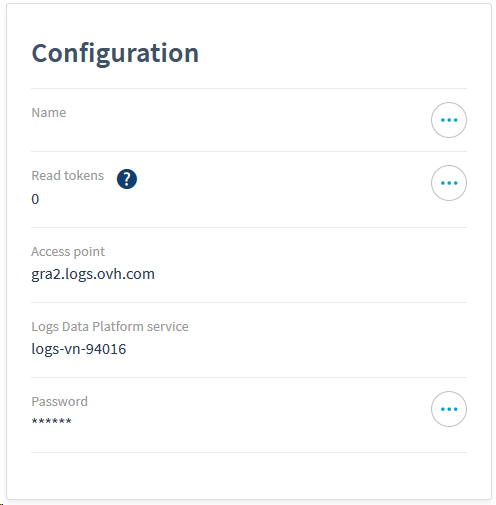

Next, create your index and give it a name, like `gravitee`

Considering the above parameters, the Helm gravitee configuration will be as

```yaml
es:
  protocol: https
  cluster: graylog-gra2
  index: logs-XXXXX-i-gravitee
  host: gra2.logs.ovh.com
  port: 9200
  security:
    enabled: true
    username: logs-XXXX
    password: XXXX
```


### with K8s

We need to gather some ElasticSearch configuration values

In [ ]:
ES_PROTOCOL=$(kubectl get service -l release=my-elasticsearch -o jsonpath="{.items[0].spec.ports[0].name}")
ES_PORT=$(kubectl get service -l release=my-elasticsearch -o jsonpath="{.items[0].spec.ports[0].port}")
ES_HOST=$(kubectl get service -l release=my-elasticsearch -o jsonpath="{.items[0].metadata.name}.{.items[0].metadata.namespace}.svc.cluster.local")

In [ ]:
echo Protocol: $ES_PROTOCOL, Host: $ES_HOST, Port: $ES_PORT

## Gravitee installation

The first step is to build the helm [chart](https://github.com/gravitee-io/gravitee-kubernetes/tree/master/gravitee).

In [ ]:
curl -OL https://github.com/gravitee-io/gravitee-kubernetes/archive/master.zip

In [ ]:
unzip -ou master.zip

In [ ]:
helm package gravitee-kubernetes-*/gravitee/ # build chart

In [ ]:
kubectl create secret tls apis.ovh-cert --key ./tls.key --cert ./tls.crt

Generate bcrypt (`$2a$` version) hash.

You could use an online generator such as https://www.browserling.com/tools/bcrypt

In [ ]:
ADMIN_PASSWD='$2a$10$bCwdwiJD3rv9xYH1fHBmK.PNbccheIeXT3rpdtHkvVRdaYHMrcam2'

In [ ]:
cat > config.yml <<EOF

adminPasswordBcrypt: $ADMIN_PASSWD

jwtSecret: myD3m0JWT4S3cr3t

mongo:
  rsEnabled: false
  dbhost: $MONGODB_GRAVITEE_USER:$MONGODB_GRAVITEE_PASS@$MONGODB_HOST
  dbname: $MONGODB_DB
  dbport: $MONGODB_PORT

#es:
#  protocol: $ES_PROTOCOL
#  host: $ES_HOST
#  port: $ES_PORT
 
es:
  cluster: graylog-gra2
  index: logs-vn-94016-i-demo-gravitee
  endpoints:
    - https://gra2.logs.ovh.com:9200/
  security:
    enabled: true
    username: logs-vn-94016
    password: zb1xNHlQHvZrnjWB!
  
ui:
  ingress:
    path: /
    hosts:
      - dev.apis.ovh ## for the development team
    tls:
    - hosts:
      - dev.apis.ovh
      secretName: apis.ovh-cert

api:
  ingress:
    path: /management ## default path value for the api path
    hosts:
      - dev.apis.ovh
    tls:
    - hosts:
      - dev.apis.ovh
      secretName: apis.ovh-cert

gateway:
  ingress:
    path: /
    hosts:
      - app.apis.ovh ## public access point
    tls:
    - hosts:
      - app.apis.ovh
      secretName: apis.ovh-cert
      
EOF

In [ ]:
helm del --purge gravitee # delete if already installed

In [ ]:
helm install --debug --name gravitee gravitee-1.23.1.tgz -f config.yml

Check that the pods are up and running

In [ ]:
kubectl get pods -l release=gravitee